In [1]:
! pip install scipy --quiet
! pip install tenacity --quiet
! pip install tiktoken --quiet
! pip install termcolor --quiet
! pip install openai --quiet

In [1]:
import json
from openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored  
import os
# client = OpenAI()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
GPT_MODEL= os.getenv("GPT_MODEL")


In [2]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model=GPT_MODEL):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice=tool_choice,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e
def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "function": "magenta",
    }
    
    for message in messages:
        if message["role"] == "system":
            print(colored(f"system: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "user":
            print(colored(f"user: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and message.get("function_call"):
            print(colored(f"assistant: {message['function_call']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and not message.get("function_call"):
            print(colored(f"assistant: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "function":
            print(colored(f"function ({message['name']}): {message['content']}\n", role_to_color[message["role"]]))


In [3]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "format": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                        "description": "The temperature unit to use. Infer this from the users location.",
                    },
                },
                "required": ["location", "format"],
            },
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_n_day_weather_forecast",
            "description": "Get an N-day weather forecast",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "format": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                        "description": "The temperature unit to use. Infer this from the users location.",
                    },
                    "num_days": {
                        "type": "integer",
                        "description": "The number of days to forecast",
                    }
                },
                "required": ["location", "format", "num_days"]
            },
        }
    },
]

In [23]:
messages = []
messages.append({"role": "system", "content": "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."})
messages.append({"role": "user", "content": "What's the weather like today"})
chat_response = chat_completion_request(
    messages, tools=tools
)
assistant_message = chat_response.choices[0].message
messages.append(assistant_message)
assistant_message.content


'Sure, could you please provide me with your current location so that I can fetch the weather information for you?'

In [24]:
messages

[{'role': 'system',
  'content': "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."},
 {'role': 'user', 'content': "What's the weather like today"},
 ChatCompletionMessage(content='Sure, could you please provide me with your current location so that I can fetch the weather information for you?', role='assistant', function_call=None, tool_calls=None)]

In [25]:
messages.append({"role": "user", "content": "I'm in Glasgow, Scotland."})
chat_response = chat_completion_request(
    messages, tools=tools
)
assistant_message = chat_response.choices[0].message
messages.append(assistant_message)
assistant_message


ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ox47RUymF068xbZHOCmBs01e', function=Function(arguments='{"location":"Glasgow, Scotland","format":"celsius"}', name='get_current_weather'), type='function')])

In [26]:
messages

[{'role': 'system',
  'content': "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."},
 {'role': 'user', 'content': "What's the weather like today"},
 ChatCompletionMessage(content='Sure, could you please provide me with your current location so that I can fetch the weather information for you?', role='assistant', function_call=None, tool_calls=None),
 {'role': 'user', 'content': "I'm in Glasgow, Scotland."},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ox47RUymF068xbZHOCmBs01e', function=Function(arguments='{"location":"Glasgow, Scotland","format":"celsius"}', name='get_current_weather'), type='function')])]

In [27]:
messages = []
messages.append({"role": "system", "content": "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."})
messages.append({"role": "user", "content": "what is the weather in Glasgow today"})
# messages.append({"role": "user", "content": "what is the weather going to be like in Glasgow, Scotland over the next x days"})

chat_response = chat_completion_request(
    messages, tools=tools
)
assistant_message = chat_response.choices[0].message
messages.append(assistant_message)
assistant_message


ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_GNTaCDQVCnO0Bh7jXI9xra2r', function=Function(arguments='{"location":"Glasgow","format":"celsius"}', name='get_current_weather'), type='function')])

In [28]:
messages = []
messages.append({"role": "system", "content": "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."})
messages.append({"role": "user", "content": "what is the weather going to be like in Glasgow, Scotland over the next x days"})
chat_response = chat_completion_request(
    messages, tools=tools
)
assistant_message = chat_response.choices[0].message
messages.append(assistant_message)
assistant_message


ChatCompletionMessage(content='Sure, I can help with that. Please provide the number of days for the weather forecast in Glasgow, Scotland.', role='assistant', function_call=None, tool_calls=None)

In [29]:
messages.append({"role": "user", "content": "5 days"})
chat_response = chat_completion_request(
    messages, tools=tools
)
chat_response.choices[0]


Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_lZjGmuDaQTjsVSlqF4Uqg4hl', function=Function(arguments='{"location":"Glasgow, Scotland","format":"celsius","num_days":5}', name='get_n_day_weather_forecast'), type='function')]))

In [30]:
messages

[{'role': 'system',
  'content': "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."},
 {'role': 'user',
  'content': 'what is the weather going to be like in Glasgow, Scotland over the next x days'},
 ChatCompletionMessage(content='Sure, I can help with that. Please provide the number of days for the weather forecast in Glasgow, Scotland.', role='assistant', function_call=None, tool_calls=None),
 {'role': 'user', 'content': '5 days'}]

In [31]:
# in this cell we force the model to use get_n_day_weather_forecast
messages = []
messages.append({"role": "system", "content": "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."})
messages.append({"role": "user", "content": "Give me a weather report for Toronto, Canada."})
chat_response = chat_completion_request(
    messages, tools=tools, tool_choice={"type": "function", "function": {"name": "get_n_day_weather_forecast"}}
)
chat_response.choices[0].message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_4MVEzhpdLd7eZEJjvzgGPQLq', function=Function(arguments='{"location":"Toronto, Canada","format":"celsius","num_days":1}', name='get_n_day_weather_forecast'), type='function')])

In [32]:
messages = []
messages.append({"role": "system", "content": "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."})
messages.append({"role": "user", "content": "what is the weather going to be like in San Francisco and Glasgow over the next 4 days"})
chat_response = chat_completion_request(
    messages, tools=tools, model=GPT_MODEL
)

assistant_message = chat_response.choices[0].message.tool_calls
assistant_message

[ChatCompletionMessageToolCall(id='call_0kVe2DrPVdbXE6q0LQF6NnIL', function=Function(arguments='{"location": "San Francisco", "format": "celsius", "num_days": 4}', name='get_n_day_weather_forecast'), type='function'),
 ChatCompletionMessageToolCall(id='call_6hLDY7WLlN2lPz7QKvG5rpGL', function=Function(arguments='{"location": "Glasgow", "format": "celsius", "num_days": 4}', name='get_n_day_weather_forecast'), type='function')]

In [8]:
def heapify(arr, n, i):
    largest = i
    l = 2 * i + 1
    r = 2 * i + 2

    if l < n and arr[i] < arr[l]:
        largest = l

    if r < n and arr[largest] < arr[r]:
        largest = r

    if largest != i:
        arr[i], arr[largest] = arr[largest], arr[i]
        print(arr)
        heapify(arr, n, largest)

def heap_sort(arr):
    n = len(arr)
    for i in range(n // 2 - 1, -1, -1):
        heapify(arr, n, i)

    for i in range(n-1, 0, -1):
        arr[i], arr[0] = arr[0], arr[i]
        heapify(arr, i, 0)
    return arr

l = [100, 3, 93, 81, 74, 54, 65, 51, 43, 35, 28, 16, 75, 48, 20, 17, 55, 99, 62]
print("Heap Sort:", heap_sort(l.copy()))


[100, 3, 93, 81, 74, 54, 65, 51, 99, 35, 28, 16, 75, 48, 20, 17, 55, 43, 62]
[100, 3, 93, 81, 74, 54, 65, 55, 99, 35, 28, 16, 75, 48, 20, 17, 51, 43, 62]
[100, 3, 93, 81, 74, 75, 65, 55, 99, 35, 28, 16, 54, 48, 20, 17, 51, 43, 62]
[100, 3, 93, 99, 74, 75, 65, 55, 81, 35, 28, 16, 54, 48, 20, 17, 51, 43, 62]
[100, 99, 93, 3, 74, 75, 65, 55, 81, 35, 28, 16, 54, 48, 20, 17, 51, 43, 62]
[100, 99, 93, 81, 74, 75, 65, 55, 3, 35, 28, 16, 54, 48, 20, 17, 51, 43, 62]
[100, 99, 93, 81, 74, 75, 65, 55, 62, 35, 28, 16, 54, 48, 20, 17, 51, 43, 3]
[99, 3, 93, 81, 74, 75, 65, 55, 62, 35, 28, 16, 54, 48, 20, 17, 51, 43, 100]
[99, 81, 93, 3, 74, 75, 65, 55, 62, 35, 28, 16, 54, 48, 20, 17, 51, 43, 100]
[99, 81, 93, 62, 74, 75, 65, 55, 3, 35, 28, 16, 54, 48, 20, 17, 51, 43, 100]
[99, 81, 93, 62, 74, 75, 65, 55, 43, 35, 28, 16, 54, 48, 20, 17, 51, 3, 100]
[93, 81, 3, 62, 74, 75, 65, 55, 43, 35, 28, 16, 54, 48, 20, 17, 51, 99, 100]
[93, 81, 75, 62, 74, 3, 65, 55, 43, 35, 28, 16, 54, 48, 20, 17, 51, 99, 100]

In [9]:
def fact(n):
    if n<=1:
        return 1
    return n*fact(n-1)
fact(4)

24

In [10]:
arr = [100, 3, 93, 81, 74, 54, 65, 51, 99, 35, 28, 16, 75, 48, 20, 17, 55, 43, 62]
mid = arr[int(len(arr)/2)]
print(mid)
counter = 0
def swap(counter,arr, mid):
    if arr[counter]>mid:
        arr


35

19

In [1]:
import requests
import os

def monthly_data():
        """ monthly data"""
        try:
            url = os.getenv("login_api")
            response = requests.get(url)
            if response.status_code == 200:
                print(response.json())
                # logger.info("monthly data fetched")
                return response.json()
        except Exception as e:
            # logger.info("error in monthly data fetching",e)
            print(e)

data = monthly_data()

{'rc': 0, 'message': 'SUCCESS', 'application': 'AMR', 'welcome_message': "Now, track your electricity consumption on your phone! Xenius SEMS app allows you to monitor your consumption, recharge your prepaid meters online and also compare your electricity bills over time.What's more? This version of the app opens up possibilities of viewing your sanctioned load, setting notifications for Source Change, Low Balance, Power Cut / Restore and more.Facing any issues? Get connected with the support team through your Settings. We hope our app helps you track your electricity usage and optimise accordingly.", 'app_base_url': 'www.myxenius.com', 'payment_trans': 'If the recharge is conducted using a Debit/Commercial/Corporate Card, MDR charges will be subtracted from the recharge amount', 'resource': {'android_version': '15', 'ios_version': '1', 'mobile_app_status': 'Y', 'location_id': '2121901', 'tp_token_id': '212190142a', 'ism_token': None, 'login_count': '226', 'device_app_ver': '1.0.5', 'fl

In [8]:
output = data['resource']
values = {}
if float(output['balance_amount'])<0:
    values['balance'] = output['balance_amount']
if output['overload_grid']in ["y", "Y"]:
    values["overload_grid"] = output['overload_grid'],
elif output['overload_dg']in ["y", "Y"]:
    values["overload_dg"]= output['overload_dg']

In [9]:
values

{'balance': '-77871.42', 'overload_grid': ('Y',)}

In [13]:
n = 10
l = {0:10}
for i in range(1,25):
    n = n + ((n*10)/100)
    l[i] = round(n, 2)
print(l)

{0: 10, 1: 11.0, 2: 12.1, 3: 13.31, 4: 14.64, 5: 16.11, 6: 17.72, 7: 19.49, 8: 21.44, 9: 23.58, 10: 25.94, 11: 28.53, 12: 31.38, 13: 34.52, 14: 37.97, 15: 41.77, 16: 45.95, 17: 50.54, 18: 55.6, 19: 61.16, 20: 67.27, 21: 74.0, 22: 81.4, 23: 89.54, 24: 98.5}


In [14]:
l

{0: 10,
 1: 11.0,
 2: 12.1,
 3: 13.31,
 4: 14.64,
 5: 16.11,
 6: 17.72,
 7: 19.49,
 8: 21.44,
 9: 23.58,
 10: 25.94,
 11: 28.53,
 12: 31.38,
 13: 34.52,
 14: 37.97,
 15: 41.77,
 16: 45.95,
 17: 50.54,
 18: 55.6,
 19: 61.16,
 20: 67.27,
 21: 74.0,
 22: 81.4,
 23: 89.54,
 24: 98.5}

In [8]:
import matplotlib.pyplot as plt


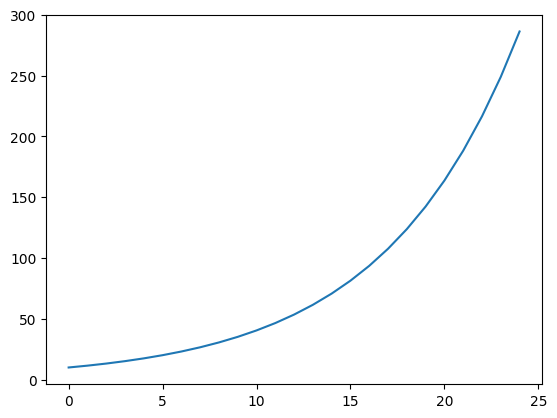

In [11]:
plt.plot(l.keys(),l.values())
plt.show()